In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from db.database import Database
from db.models import Blueprint
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import ast
import numpy as np
from collections import Counter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
db = Database()
topics = {topic.topic_id: topic for topic in db.get_topics()}
posts = {post.post_id: post for post in db.get_posts()}
blueprints = {bp.id: bp for bp in db.get_all_blueprints()}

Loading blueprints: 100%|██████████| 2232/2232 [00:01<00:00, 1212.98it/s]


In [3]:
print("work" in stopwords.words('english'))  # Check if "it" is in the stopwords list

False


In [4]:
import tqdm
from util.lang_identification import identify_language_yaml

non_english = {} 
for bp in tqdm.tqdm(blueprints.values(), desc="Detecting languages"):
    lang = identify_language_yaml(bp.blueprint_code)
    if lang != 'en':
        non_english[bp] = lang
        
for bp in non_english:
    blueprints.pop(bp.id)
blueprints.__len__()

groups = db.get_blueprints_per_topic()

english_ids = set(blueprints.keys())   
filtered_groups = {
    topic_id: [bp for bp in bps if bp.id in english_ids]
    for topic_id, bps in groups.items()
}
filtered_groups.keys().__len__()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Detecting languages: 100%|██████████| 2232/2232 [00:38<00:00, 58.00it/s]


1211

In [5]:
def remove_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    
    for code_tag in soup.find_all("code", {"class":["lang-auto","lang-yaml"]}):
        code_tag.decompose()
    
    for a_tag in soup.find_all("a"):
        a_tag.decompose()
    
    return soup.get_text().replace("\n", " ").strip()

In [6]:
def preprocessing(text, ignorable_words=None):
    if ignorable_words is None:
        ignorable_words = []
    ignorable_words = ignorable_words + ["blueprint", "automation", "entity", "work"]
    text = remove_html(text)
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r"’", r"'", text)
    text = re.sub(r"[^\w'\s]", "", text)
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words("english")]
    text = " ".join(text)
    text = re.sub("|".join(ignorable_words), "", text, flags=re.IGNORECASE)
    return text

### sklearn TfIdf

In [8]:
def fit_trans(str: list[str]):
    tfidf = TfidfVectorizer()
    res = tfidf.fit_transform(str)
    return res, tfidf

In [24]:
def get_corpus_and_url(topic_id):
    topic = topics.get(topic_id)
    posts = db.get_posts_by_topic_id(topic_id)
    tags = topic.tags
    if isinstance(tags, str):
        try:
            tags = ast.literal_eval(tags)
            lemmatizer = WordNetLemmatizer()
            tags = [lemmatizer.lemmatize(tag) for tag in tags]
        except (ValueError, SyntaxError):
            tags = [tags]
            lemmatizer = WordNetLemmatizer()
            tags = [lemmatizer.lemmatize(tag) for tag in tags]
    post_contents = [post.cooked for post in posts]
    corpus = [preprocessing(text, ignorable_words=tags) for text in post_contents]
    corpus = " ".join(corpus)
    return corpus, topic.topic_url

corpus, url = get_corpus_and_url(list(topics.keys())[120])
corpus, url

("hi namron 8button switch want use different thing send action example  ing try use 4 different action 4 different thing dim turn turn  se action changed back  processed option lightzigbee_23 wallwitch lightzigbee_24 lamp home can't test look right",
 'https://community.home-assistant.io//t/one-automation-to-manage-all-buttons-on-a-switch/336607')

In [25]:
res, tfidf = fit_trans([corpus])
terms = tfidf.get_feature_names_out()
df = pd.DataFrame(res.toarray(), columns=terms)
print(df)

    8button    action      back       can   changed  different       dim  \
0  0.136083  0.408248  0.136083  0.136083  0.136083   0.408248  0.136083   

    example        hi      home  ...        se      send    switch      test  \
0  0.136083  0.136083  0.136083  ...  0.136083  0.136083  0.136083  0.136083   

      thing       try      turn       use  wallwitch      want  
0  0.272166  0.136083  0.272166  0.272166   0.136083  0.136083  

[1 rows x 29 columns]


In [ ]:
def get_top_keywords(tfidf_matrix, feature_names, top_n=5):
    top_keywords = []
    for row in tfidf_matrix:
        # Convert sparse row to dense array
        row_array = row.toarray().flatten()
        # Get indices of top N scores
        top_indices = np.argsort(row_array)[-top_n:][::-1]
        # Map indices to feature names
        top_terms = [(feature_names[i], row_array[i]) for i in top_indices]
        top_keywords.append(top_terms)
    return top_keywords

# Get top keywords for each document
top_keywords_per_doc = get_top_keywords(res, terms, top_n=3)

# Print top keywords for the first few documents
for i, keywords in enumerate(top_keywords_per_doc[:3]):
    print(f"Document {i+1}: {keywords}")

Document 1: [('action', 0.408248290463863), ('different', 0.408248290463863), ('use', 0.2721655269759087)]


In [ ]:
keywords = Counter()
for topic_id in tqdm.tqdm(list(filtered_groups.keys()), desc="Extracting keywords"):
    corpus, _ = get_corpus_and_url(topic_id)
    if not corpus.strip():
        continue
    res, tfidf = fit_trans([corpus])
    terms = tfidf.get_feature_names_out()
    topic_keywords = get_top_keywords(res, terms, top_n=10)
    flat_keywords = [entry[0] for sublist in topic_keywords for entry in sublist]
    keywords.update(flat_keywords)

print(keywords.most_common(50), "\n")

Extracting keywords: 100%|██████████| 1211/1211 [10:33<00:00,  1.91it/s]

[('input', 374), ('button', 350), ('name', 324), ('action', 322), ('device', 229), ('condition', 223), ('description', 220), ('press', 213), ('light', 201), ('sensor', 182), ('time', 153), ('switch', 148), ('use', 147), ('selector', 144), ('event', 126), ('one', 116), ('remote', 116), ('turn', 111), ('state', 111), ('thanks', 104), ('home', 98), ('trigger', 97), ('set', 91), ('temperature', 88), ('would', 87), ('default', 82), ('brightness', 73), ('sequence', 72), ('control', 70), ('command', 70), ('scene', 69), ('get', 68), ('change', 67), ('like', 66), ('_id', 62), ('using', 61), ('notification', 59), ('value', 58), ('long', 55), ('mode', 55), ('service', 54), ('assistant', 52), ('hi', 49), ('double', 49), ('dimmer', 49), ('motion', 48), ('single', 47), ('ha', 47), ('error', 46), ('ing', 46)] 



In [32]:
for keyword in keywords.most_common(50):
    print(keyword)

('input', 374)
('button', 350)
('name', 324)
('action', 322)
('device', 229)
('condition', 223)
('description', 220)
('press', 213)
('light', 201)
('sensor', 182)
('time', 153)
('switch', 148)
('use', 147)
('selector', 144)
('event', 126)
('one', 116)
('remote', 116)
('turn', 111)
('state', 111)
('thanks', 104)
('home', 98)
('trigger', 97)
('set', 91)
('temperature', 88)
('would', 87)
('default', 82)
('brightness', 73)
('sequence', 72)
('control', 70)
('command', 70)
('scene', 69)
('get', 68)
('change', 67)
('like', 66)
('_id', 62)
('using', 61)
('notification', 59)
('value', 58)
('long', 55)
('mode', 55)
('service', 54)
('assistant', 52)
('hi', 49)
('double', 49)
('dimmer', 49)
('motion', 48)
('single', 47)
('ha', 47)
('error', 46)
('ing', 46)


### Rake

In [20]:
from multi_rake import Rake
rake_topic_id = list(filtered_groups.keys())[115]
rake_posts = db.get_posts_by_topic_id(rake_topic_id)
cleaned_texts_topic = [remove_html(post.cooked) for post in rake_posts]
cleaned_texts_topic.insert(0, str(topics.get(rake_topic_id).title))
rake = Rake(min_chars=3, max_words=1)
rake.stopwords.add('blueprint')
full_text = " ".join(cleaned_texts_topic)
keywords = rake.apply(full_text)
keywords, full_text, rake_posts[0].post_url

([('deconz', 1.0),
  ('this', 1.0),
  ('ups', 1.0),
  ('cool', 1.0),
  ('single', 1.0),
  ('thanks', 1.0),
  ('device_id', 1.0),
  ('hey', 1.0),
  ('error', 1.0),
  ('undefinederror', 1.0),
  ('hassio/supervised', 1.0),
  ('100%', 1.0),
  ('hmm', 1.0),
  ('events', 1.0),
  ('deconz_event', 1.0),
  ('anyways', 1.0),
  ('but', 1.0)],
 'deCONZ - Ikea Tradfri Shortcut Button based on this  Blueprint. Nice I haven’t got a shortcut button myself to test for you. But the code looks good Thanks! I really like them. I got two of them and they work good so far. Deconz already supports them but they do not show up in the phoscon app. In HA you can not directly control them via Devices, but the events work. So the Blueprint makes even more sense here! How do I have to add the shortcut button in order to use that blueprint? First adding the button to deconz? Search for new devices in the Phoscon app (it wont show up there as the app is not updated yet). Just look into your devices in the Deconz Int

### spaCy

In [31]:
import spacy 
nlp = spacy.load("en_core_web_md")
#nlp.add_pipe("keyword_extractor", last=True, config={"top_n": 10, "min_ngram": 3, "max_ngram": 3, "strict": True, "top_n_sent": 3})
spacy_topic_id = list(filtered_groups.keys())[120]
spacy_posts = db.get_posts_by_topic_id(spacy_topic_id)
cleaned_texts_spacy = [remove_html(post.cooked) for post in spacy_posts]
cleaned_texts_spacy.insert(0, str(topics.get(spacy_topic_id).title))
docs = nlp(" ".join(cleaned_texts_spacy))
entities = Counter([token.pos_ for token in docs])
docs, entities, topics.get(spacy_topic_id).tags

(ZHA - IKEA Tradfri on/off remote dual function Inspired by  I tweaked his blueprint for the IKEA Tradfri On/Off switch. Because I don’t use the dimmer function I use the move and move_with_on_off events to control a switch.  Blueprint Code Click the badge to import this Blueprint: (needs Home Assistant Core 2021.3 or higher),
 Counter({'NOUN': 12,
          'PROPN': 11,
          'VERB': 8,
          'PUNCT': 6,
          'DET': 6,
          'ADP': 4,
          'PRON': 4,
          'ADJ': 3,
          'PART': 3,
          'SYM': 2,
          'SPACE': 2,
          'CCONJ': 2,
          'SCONJ': 1,
          'AUX': 1,
          'NUM': 1}),
 '["zha", "blueprint"]')

In [36]:
import spacy
from collections import Counter
from string import punctuation
nlp = spacy.load("en_core_web_sm")
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    doc = nlp(text.lower()) 
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
    return result
text = " ".join(cleaned_texts_spacy)
output = set(get_hotwords(text))
most_common_list = Counter(output).most_common(10)
for item in most_common_list:
  print(item)

('assistant', 1)
('core', 1)
('dual', 1)
('higher', 1)
('dimmer', 1)
('function', 1)
('zha', 1)
('badge', 1)
('ikea', 1)
('switch', 1)


### YAKE

In [41]:
def yake_preprocessing(text):
    text = remove_html(text)
    text = text.lower()
    text = re.sub(r'’', r"'", text)
    text = re.sub(r"[^\w'\s]", '', text)
    return text

In [51]:
import yake
yake_topic_id = list(filtered_groups.keys())[250]
yake_posts = db.get_posts_by_topic_id(yake_topic_id)
cleaned_texts_yake = [yake_preprocessing(post.cooked) for post in yake_posts]
cleaned_texts_yake.insert(0, yake_preprocessing(str(topics.get(yake_topic_id).title)))
yake_kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=5)
yake_kw_extractor.stopword_set.add('blueprint')
tags = topics.get(topic_id).tags
if isinstance(tags, str):
    try:
        tags = ast.literal_eval(tags)
    except (ValueError, SyntaxError):
        tags = [tags]
for tag in tags:
    yake_kw_extractor.stopword_set.add(tag.lower())
yake_keywords = yake_kw_extractor.extract_keywords(" ".join(cleaned_texts_yake))
yake_keywords, tags, yake_posts[0].post_url

([('button', 0.008983209970610917),
  ('remote', 0.01101808167018563),
  ('mode', 0.012965884183608533),
  ('light', 0.0135164559500364),
  ('press', 0.016636531121412636)],
 [],
 'https://community.home-assistant.io//t/zha-linkind-5-key-remote-control-button-zbt-rgbw-switch-d0801-using-switch-modes/358781/1')

In [ ]:
yake_kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=2)
yake_kw_extractor.stopword_set.add('blueprint')
keywords = Counter()
for topic_id in tqdm.tqdm(list(filtered_groups.keys()), desc="Extracting keywords"):
    posts = db.get_posts_by_topic_id(topic_id)
    cleaned_texts = [yake_preprocessing(post.cooked) for post in posts]
    cleaned_texts.insert(0, yake_preprocessing(topics.get(topic_id).title))
    full_text = " ".join(cleaned_texts)
    tags = topics.get(topic_id).tags
    if isinstance(tags, str):
        try:
            tags = ast.literal_eval(tags)
        except (ValueError, SyntaxError):
            tags = [tags]
    #print(f"Topic ID: {topic_id}, Tags: {tags}")
    for tag in tags:
        yake_kw_extractor.stopword_set.add(tag.lower())
    yake_keywords = yake_kw_extractor.extract_keywords(full_text)
    yake_keywords = [kw for kw, score in yake_keywords]
    keywords.update(yake_keywords)
keywords

Extracting keywords: 100%|██████████| 1211/1211 [03:22<00:00,  5.97it/s]


Counter({'press': 117,
         'light': 105,
         'work': 81,
         'remote': 74,
         'device': 70,
         'temperature': 56,
         'action': 56,
         'home': 55,
         'turn': 55,
         'scene': 47,
         'motion': 45,
         'sensor': 38,
         'entity': 38,
         'event': 37,
         'hue': 37,
         'ikea': 33,
         'state': 33,
         'dimmer': 32,
         'input': 32,
         'brightness': 32,
         'set': 29,
         'actions': 29,
         'lights': 29,
         'long': 28,
         'door': 27,
         'control': 26,
         'events': 25,
         'color': 25,
         'switches': 24,
         'trigger': 24,
         'works': 24,
         'media': 22,
         'assistant': 22,
         'version': 20,
         'mode': 19,
         'working': 19,
         'single': 17,
         'tradfri': 17,
         'devices': 17,
         'volume': 16,
         'window': 16,
         'hold': 16,
         'wireless': 16,
         'control

### KeyBert

In [7]:
import torch
print(torch.version.cuda)
from keybert import KeyBERT
bert_topic_id = list(filtered_groups.keys())[115]
bert_posts = db.get_posts_by_topic_id(bert_topic_id)
cleaned_texts_bert = [remove_html(post.cooked) for post in bert_posts]
cleaned_texts_bert.insert(0, str(topics.get(bert_topic_id).title))
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(" ".join(cleaned_texts_bert), keyphrase_ngram_range=(1, 1), stop_words='english', top_n=10)
keywords

11.8


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Adrian\workspace-loc\dat300\BP-classification\bpclass\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Adrian\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[('phoscon', 0.3929),
 ('deconz_event', 0.3369),
 ('ikea', 0.3358),
 ('shortcut', 0.286),
 ('button', 0.2822),
 ('buttons', 0.2743),
 ('deconz', 0.2598),
 ('blueprint', 0.2569),
 ('tradfri', 0.2526),
 ('blueprints', 0.2352)]

In [10]:
topics_df = pd.DataFrame([{
    "topic_id": topic.topic_id,
    "title": topic.title,
    "tags": topic.tags,
} for topic in topics.values()])
posts_df = pd.DataFrame([{
    "post_id": post.post_id,
    "topic_id": post.topic_id,
    "cooked": post.cooked,
} for post in posts.values()])
bp_df = pd.DataFrame([{
    "bp_id": bp.id,
    "blueprint_code": bp.blueprint_code,
    "post_id": bp.post_id,
    "description": bp.description,
} for bp in blueprints.values()])
topics_posts = topics_df.merge(posts_df, on="topic_id")
topics_bps = topics_posts.merge(bp_df, on="post_id")
topics_bps.head()

,topic_id,title,tags,post_id,cooked,bp_id,blueprint_code,description
0,255041,Nag prompt Blueprint (Android Notification),[],1220860,<p>This blueprints creates configurable nag no...,1,blueprint:\n name: Nag prompt blueprint\n de...,Nag a mobile device to do something
1,254999,Inovelli LZW36 Fan/Dimmer Scenes,"[""blueprint""]",1220678,<p>This blueprint allows you to easily create ...,2,blueprint:\n name: Inovelli \n description: ...,Use this blueprint to create automations based...
2,255699,deCONZ - IKEA five button remote,"[""switch"", ""blueprint"", ""deconz""]",1223455,"<p>This is a mix of <a href=""https://community...",3,blueprint:\n name: deCONZ - IKEA five button ...,Control anything using IKEA five button remote\n
3,255742,Set heating temperature to a configurable valu...,[],1223628,"<p>This is a blueprint, that allows to set the...",4,blueprint:\n name: Heat for certain time\n d...,Turn on heating for a given amount of time.
4,256045,Light Allowance,[],1224871,<p>This blueprint will turn a light off after ...,5,blueprint:\n name: Light Allowance\n descrip...,Turns a light off after an allotted time


In [17]:
topics_bps = topics_bps[topics_bps["topic_id"].isin(filtered_groups.keys())]
topics_posts = topics_posts[topics_posts["topic_id"].isin(filtered_groups.keys())]
topics_bps.shape, topics_posts.shape

((2196, 8), (36624, 5))

In [ ]:
kw_model = KeyBERT()
kw_dict = {}
for topic_id in topics_posts["topic_id"].unique():
    post_subset = topics_posts[topics_posts["topic_id"] == topic_id]
    bp_subset = topics_bps[topics_bps["topic_id"] == topic_id]
    texts = post_subset["cooked"].tolist()
    texts = [remove_html(post) for post in texts]
    texts.insert(0, str(topics_df.loc[topics_df["topic_id"] == topic_id, "title"].values[0]))
    texts.extend(bp_subset["description"].tolist())
    text = " ".join(texts)
    
    keywords = kw_model.extract_keywords(text,stop_words=post_subset["tags"].tolist()+["blueprint", "automation"], top_n=2)
    kw_dict[topic_id] = keywords

kw_df = pd.DataFrame(kw_dict).T
kw_df.head()

c:\Users\Adrian\workspace-loc\dat300\BP-classification\bpclass\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['deconz', 'switch'] not in stop_words.
  warnings.warn(
c:\Users\Adrian\workspace-loc\dat300\BP-classification\bpclass\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['deconz'] not in stop_words.
  warnings.warn(
c:\Users\Adrian\workspace-loc\dat300\BP-classification\bpclass\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['notification'] not in stop_words.
  warnings.warn(
c:\Users\Adrian\workspace-loc\dat300\BP-classification\bpclass\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarn

KeyboardInterrupt: 

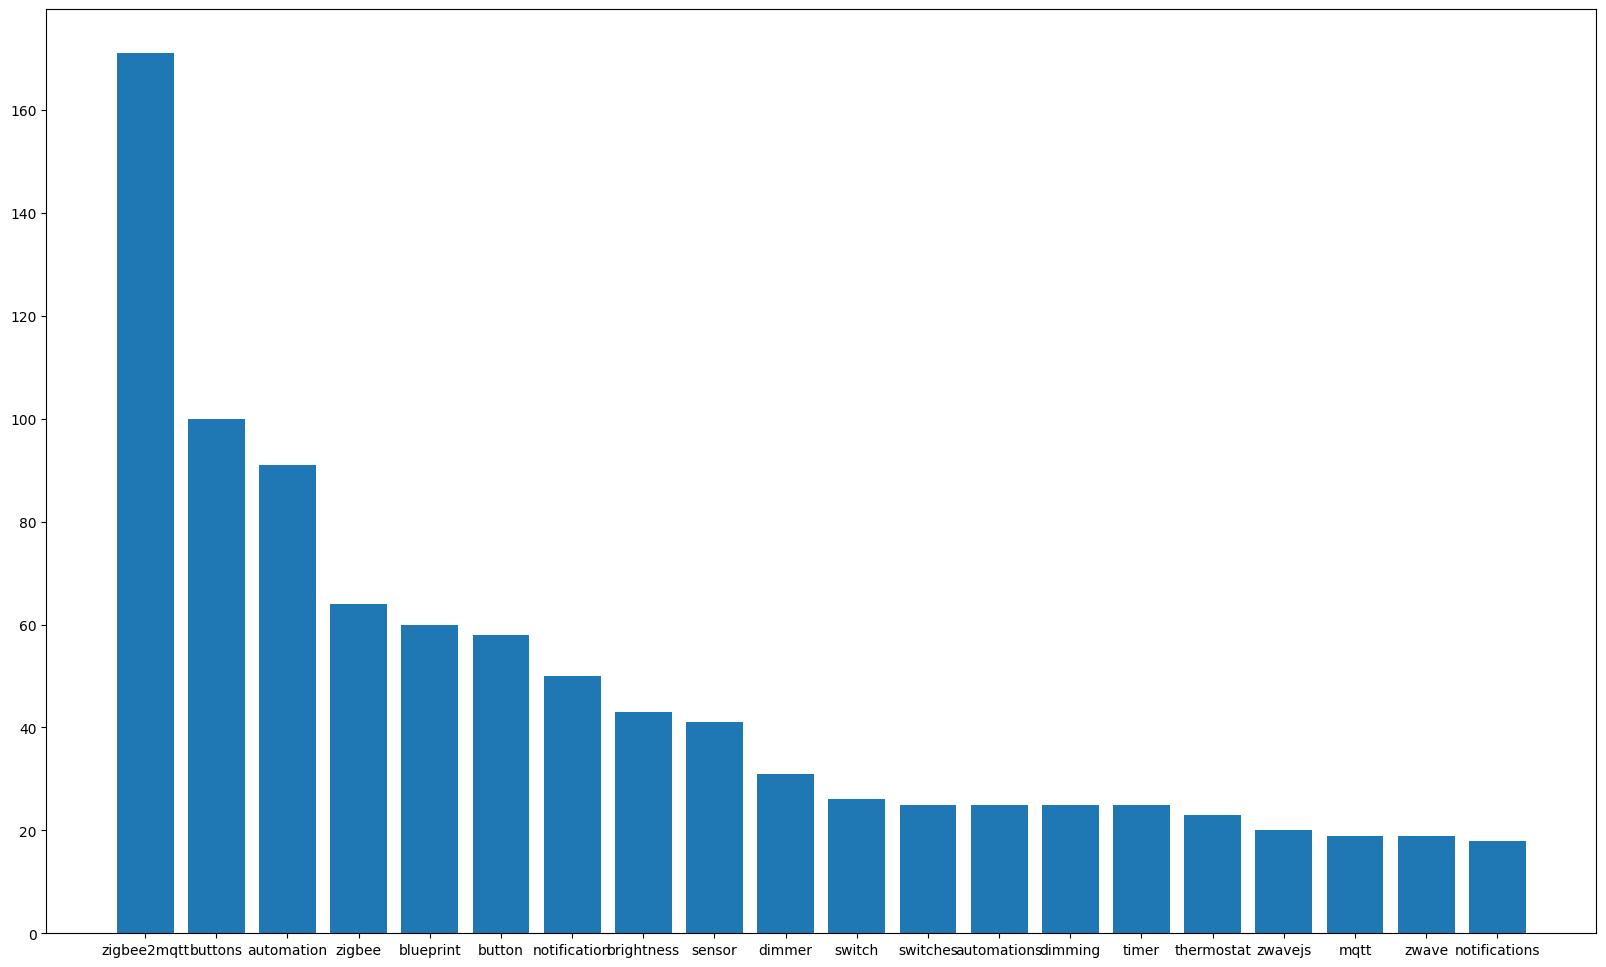

In [ ]:
import matplotlib.pyplot as plt
kw_counts = Counter((kw_df[0]+kw_df[1]).explode())
plt.figure(figsize=(20,12))
plt.bar(*zip(*kw_counts.most_common(20)))
plt.show()